# Imports

In [48]:
! pip3 install torch==1.13.0 torchvision==0.14.0 torchaudio


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [49]:
###########
# Imports #
###########

import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

import requests

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import random

In [50]:
#############
# FUNCTIONS #
#############


def get_predictions(pred, threshold=0.8, objects=None):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood is under 
    the threshold 
    
    Arguments:
    - pred: a list where each element contains a tuple that corresponds to information about the different objects; 
      Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates 
      of the bounding box corresponding to the object 
    
    Return:
    - predicted_classes: a list where each element contains a tuple that corresponds to information about the different 
      objects; Each element includes a tuple with the class name, probability of belonging to that class and the 
      coordinates of the bounding box corresponding to the object.
    """


    predicted_classes = [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) 
                        for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),
                        list(pred[0]['boxes'].detach().numpy()))]
    
    predicted_classes = [stuff for stuff in predicted_classes if stuff[1]>threshold]
    
    if objects and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in objects]
        
    return predicted_classes


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#


def draw_box(predicted_classes, image, text_th, rect_th, text_size=1):
    """
    Draw boxes around each object
    
    Arguments:
    - predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects; 
      Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the 
      bounding box corresponding to the object 
    
    image : frozen surface 
    """
    # Create a list of each detected class
    unique_classes = set([pc[0] for pc in predicted_classes])
    
    # Shuffle the colors list to pick randomly
    colors_list = [(255, 0, 0), (0, 255, 255), (0, 255, 0), (240, 110, 240), (80, 80, 220), (255, 155, 255)]  # Votre liste de couleurs ici
    random.shuffle(colors_list)
    
    # Create a dictionary to store the correspondence between each class and its color
    class_colors = {}
    
    # Assign a color to each class
    for cls in unique_classes:
        if colors_list:
            color = colors_list.pop(0)  # Remove the first color from the list
        else:
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))  # Générer une couleur aléatoire si la liste de couleurs est épuisée
        class_colors[cls] = color
    
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()
    
    # Retrieve label, probability & box
    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]
        
        # Get the color corresponding to the class
        color = class_colors[label]
        
        # Draw the rectangle with the coordinates
        cv2.rectangle(img, ((int(box[0][0])), (int(box[0][1]))), ((int(box[1][0])), (int(box[1][1]))), color, rect_th)  
        cv2.putText(img, label, ((int(box[0][0])), (int(box[0][1]))), cv2.FONT_HERSHEY_SIMPLEX, text_size, color, thickness=text_th)
        cv2.putText(img, label + ": " + str(round(probability, 2)), ((int(box[0][0])), (int(box[0][1]))), cv2.FONT_HERSHEY_SIMPLEX, text_size, color, thickness=text_th)
    
    # Show
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del(img)
    del(image)
    

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
 

def model(x):
    """
    This function calls Faster R-CNN 'model_' but save RAM
    """
    
    with torch.no_grad():
        yhat = model_(x)
    return yhat


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
 

def save_RAM(image_=False):
    """
    This function will speed up the code by freeing memory
    """
    
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

In [51]:
##############
# 91 Classes #
##############

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [52]:
#############################
# Load Pre-trained ResNet50 #
#############################

model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

/home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


done


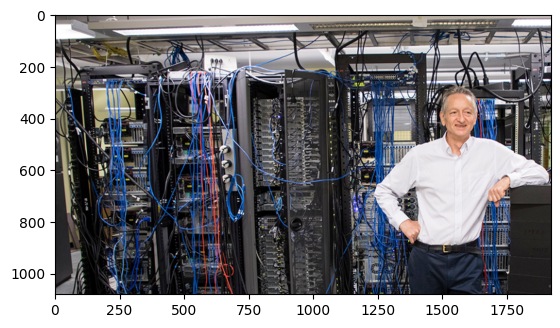

In [53]:
#######################
# Load & resize image #
#######################

img_path = 'jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image.resize([int(half * s) for s in image.size])

plt.imshow(image)
plt.show()

In [54]:
##############################################################
# Create a transform object to convert the image to a tensor #
##############################################################

transform = transforms.Compose([transforms.ToTensor()])

###############################
# Convert the image to Tensor #
###############################

img = transform(image)

#####################
# Make a prediction #
#####################

pred = model([img])

In [55]:
##########
# Labels #
##########

## 35 different class predictions, ordered by likelihood scores for potential object ##

pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

In [56]:
############################
# Likelihood of each class #
############################

pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1766, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

In [57]:
##################
# Class detected #
##################

index = pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

In [58]:
###################################
# Coordinates of the bounding box #
###################################

bounding_box = pred[0]['boxes'][0].tolist()
bounding_box

[1223.168701171875, 301.2502136230469, 1909.1724853515625, 1076.6370849609375]

In [59]:
##################
# Corners values #
##################

## These values correspond to the top-left corner and bottom-right corner of the rectangle,
## more precisely : top (t) , left (l), bottom(b), right (r), we need to round them 

t, l, r, b = [round(x) for x in bounding_box]

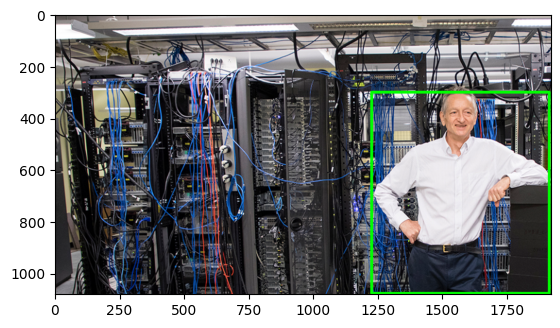

In [60]:
####################
# Plot image & box #
####################

## Convert the tensor to an Open CV array and plot the image & the box ##
img_plot = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)


## Draw Rectangle with the coordinates ##
cv2.rectangle(img_plot, (t,l), (r,b), (0, 255, 0), 10) 


## Plot ##
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

In [68]:
#################################
# Delete objects to save memory #
#################################

save_RAM(image_=True)

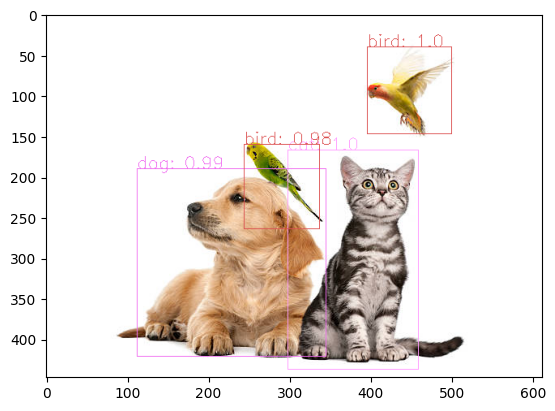

In [69]:
#############################
# Multiple object detection #
#############################

img_path = 'istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
# plt.imshow(np.array(image))
# plt.show()

img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.9)
draw_box(pred_thresh, img, rect_th=1, text_size=0.7, text_th=1)
del pred_thresh

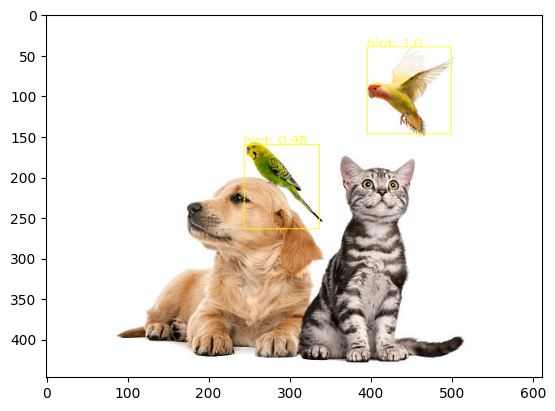

In [70]:
###################
# Class detection #
###################

pred_obj = get_predictions(pred, objects="bird")
draw_box(pred_obj,img, rect_th= 1, text_size= 0.5, text_th=1)
del pred_obj

In [71]:
save_RAM(image_=True)

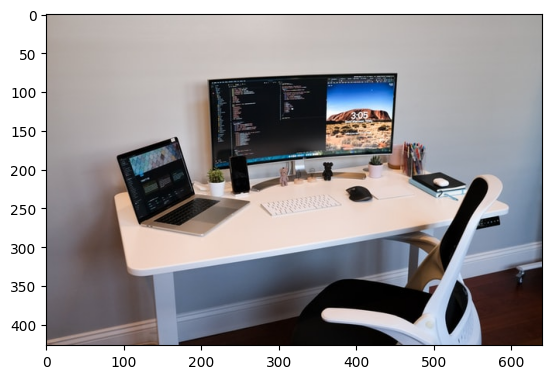

In [92]:
img_path='Office_0.jpg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

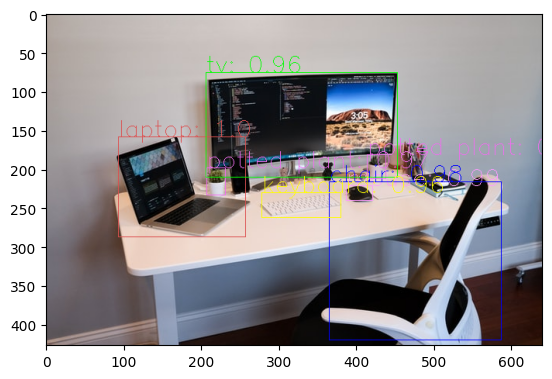

In [93]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred,threshold=0.95)
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

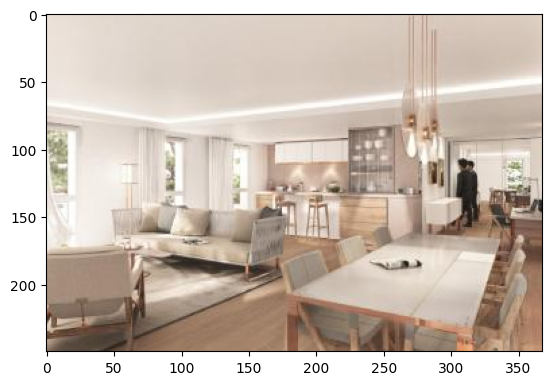

In [76]:
img_path='Appartment_0.jpg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

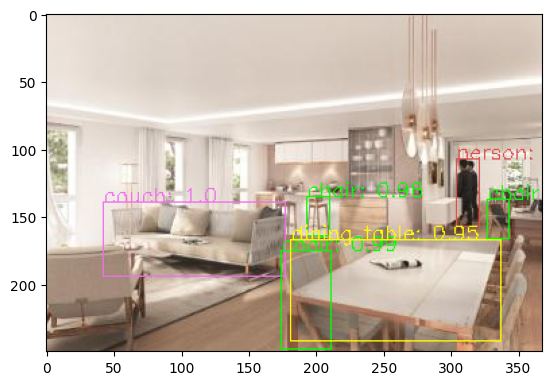

In [77]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred,threshold=0.9)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

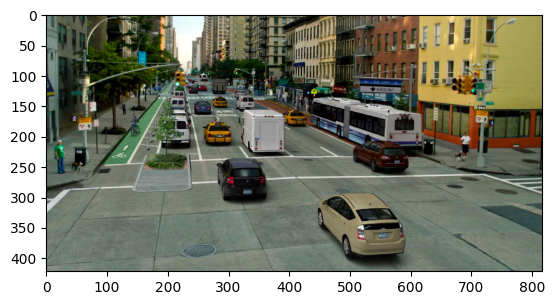

In [78]:
img_path='Cars_0.png'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

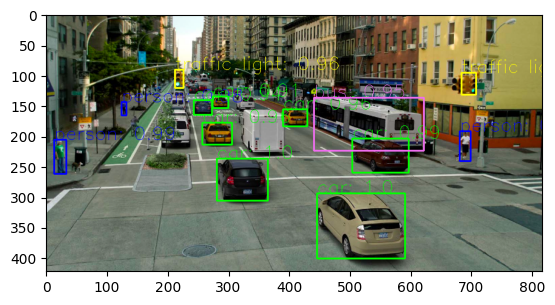

In [79]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred,threshold=0.9)
draw_box(pred_thresh,img,rect_th= 2,text_size= 1,text_th=1)
del pred_thresh

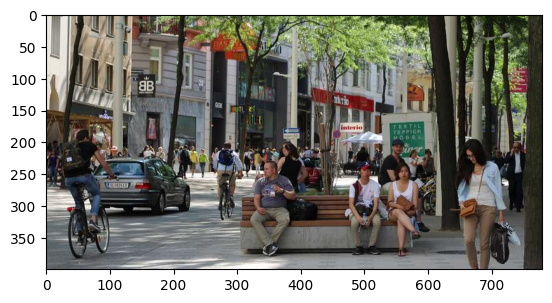

In [80]:
img_path='Street_0.jpg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

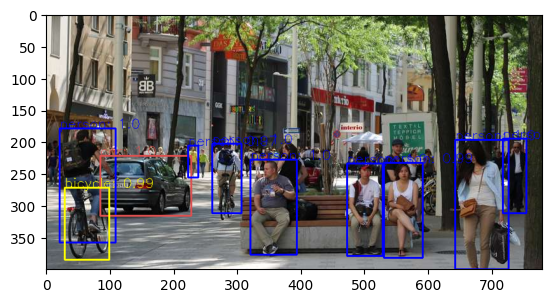

In [81]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred,threshold=0.97)
draw_box(pred_thresh,img,rect_th= 2,text_size= 0.7,text_th=1)
del pred_thresh

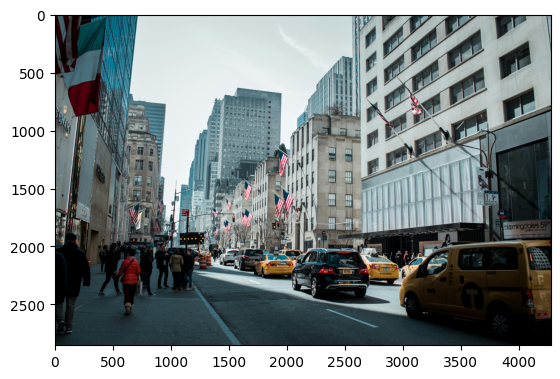

In [84]:
img_path='Street_2.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

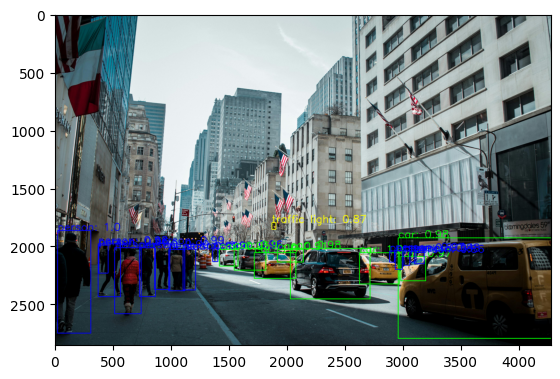

In [85]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred,threshold=0.8)
draw_box(pred_thresh,img,rect_th= 5,text_size=3 ,text_th=5)
del pred_thresh

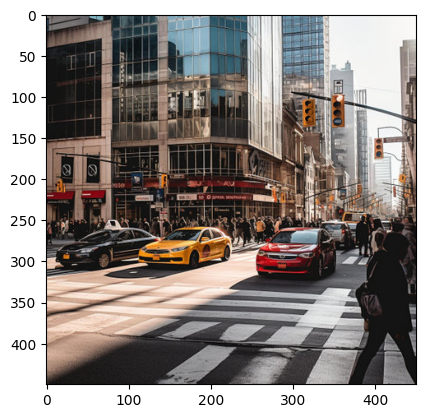

In [86]:
img_path='Street_3.jpg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

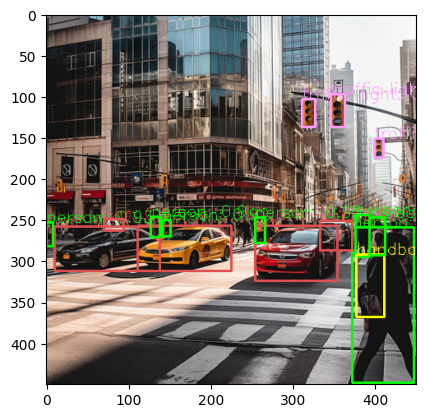

In [91]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.9)
draw_box(pred_thresh, img, rect_th= 2, text_size=0.65 ,text_th=1)
del pred_thresh

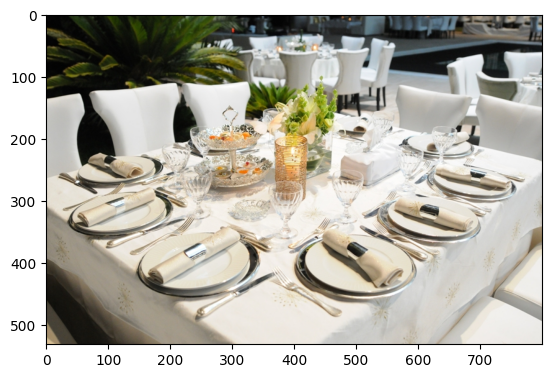

In [99]:
img_path='Table_0.jpg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

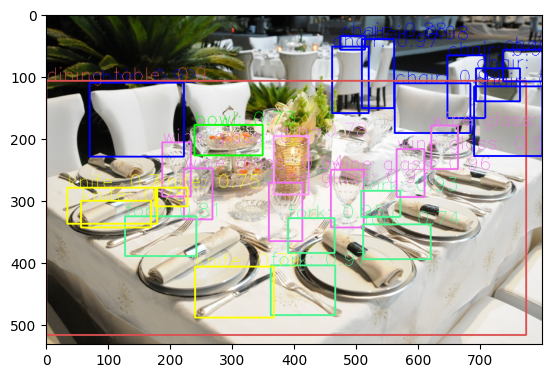

In [101]:
img = transform(image)
pred = model([img])
pred_thresh  =get_predictions(pred, threshold=0.7)
draw_box(pred_thresh, img, rect_th= 2, text_size= 1, text_th=1)
del pred_thresh

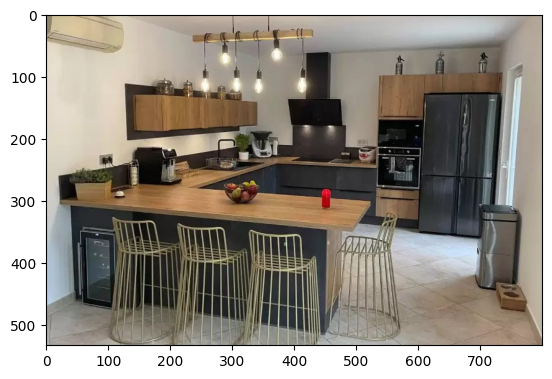

In [105]:
img_path='Kitchen_2.jpg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

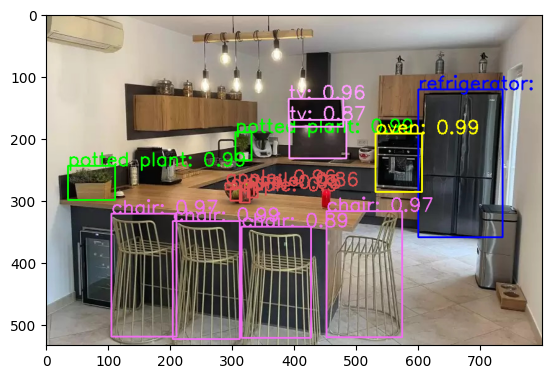

In [108]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.85)
draw_box(pred_thresh, img, rect_th= 2, text_size= 1, text_th=2)
del pred_thresh